# Problema de Negócio: Empresa Trend Jeans

## A empresa Trend Jeans!
Eduardo e Marcelo são dois brasileiros, amigos e sócios de empreendimento. Depois de vários negócios bem sucedidos, eles estão planejando entrar no mercado de moda dos USA como um modelo de negócio do tipo E-commerce.

A idéia inicial é entrar no mercado com apenas um produto e para um público específico, no caso o produto seria calças Jeans para o público masculino. O objetivo é manter o custo de operação baixo e escalar a medida que forem conseguindo clientes.

Porém, mesmo com o produto de entrada e a audiência definidos, os dois sócios não tem experiência nesse mercado de moda e portanto não sabem definir coisas básicas como preço, o tipo de calça e o material para a fabricação de cada peça.

Assim, os dois sócios contrataram uma consultoria de Ciência de Dados para responder as seguintes perguntas: 
- 1. Quantos tipos de calças e suas cores para o produto inicial? 
- 2. Quais as matérias-prima necessárias para confeccionar as calças?
- 3. Qual o melhor preço de venda para as calças? 
    - 3.1. Qual o melhor preço para bater o concorrente, incluindo preço do material e mão de obra de costura.
    - 3.2. Calcular o lucro de cada peça, tirando o preço do material e mão de obra de costura

A principal concorrente da empresa Trend Jeans é a americana H&M.

## Design de ETL

### Imports

In [1]:
import re
import sqlite3
import requests
import pandas as pd
import numpy as np
import plotly.express as px

from bs4             import BeautifulSoup
from datetime        import datetime
from sqlalchemy      import create_engine
from IPython.display import Image

### Funções auxiliares

In [51]:
pd.set_option('float_format', '{:.2f}'.format)

## Desenho da Arquitetura do ETL

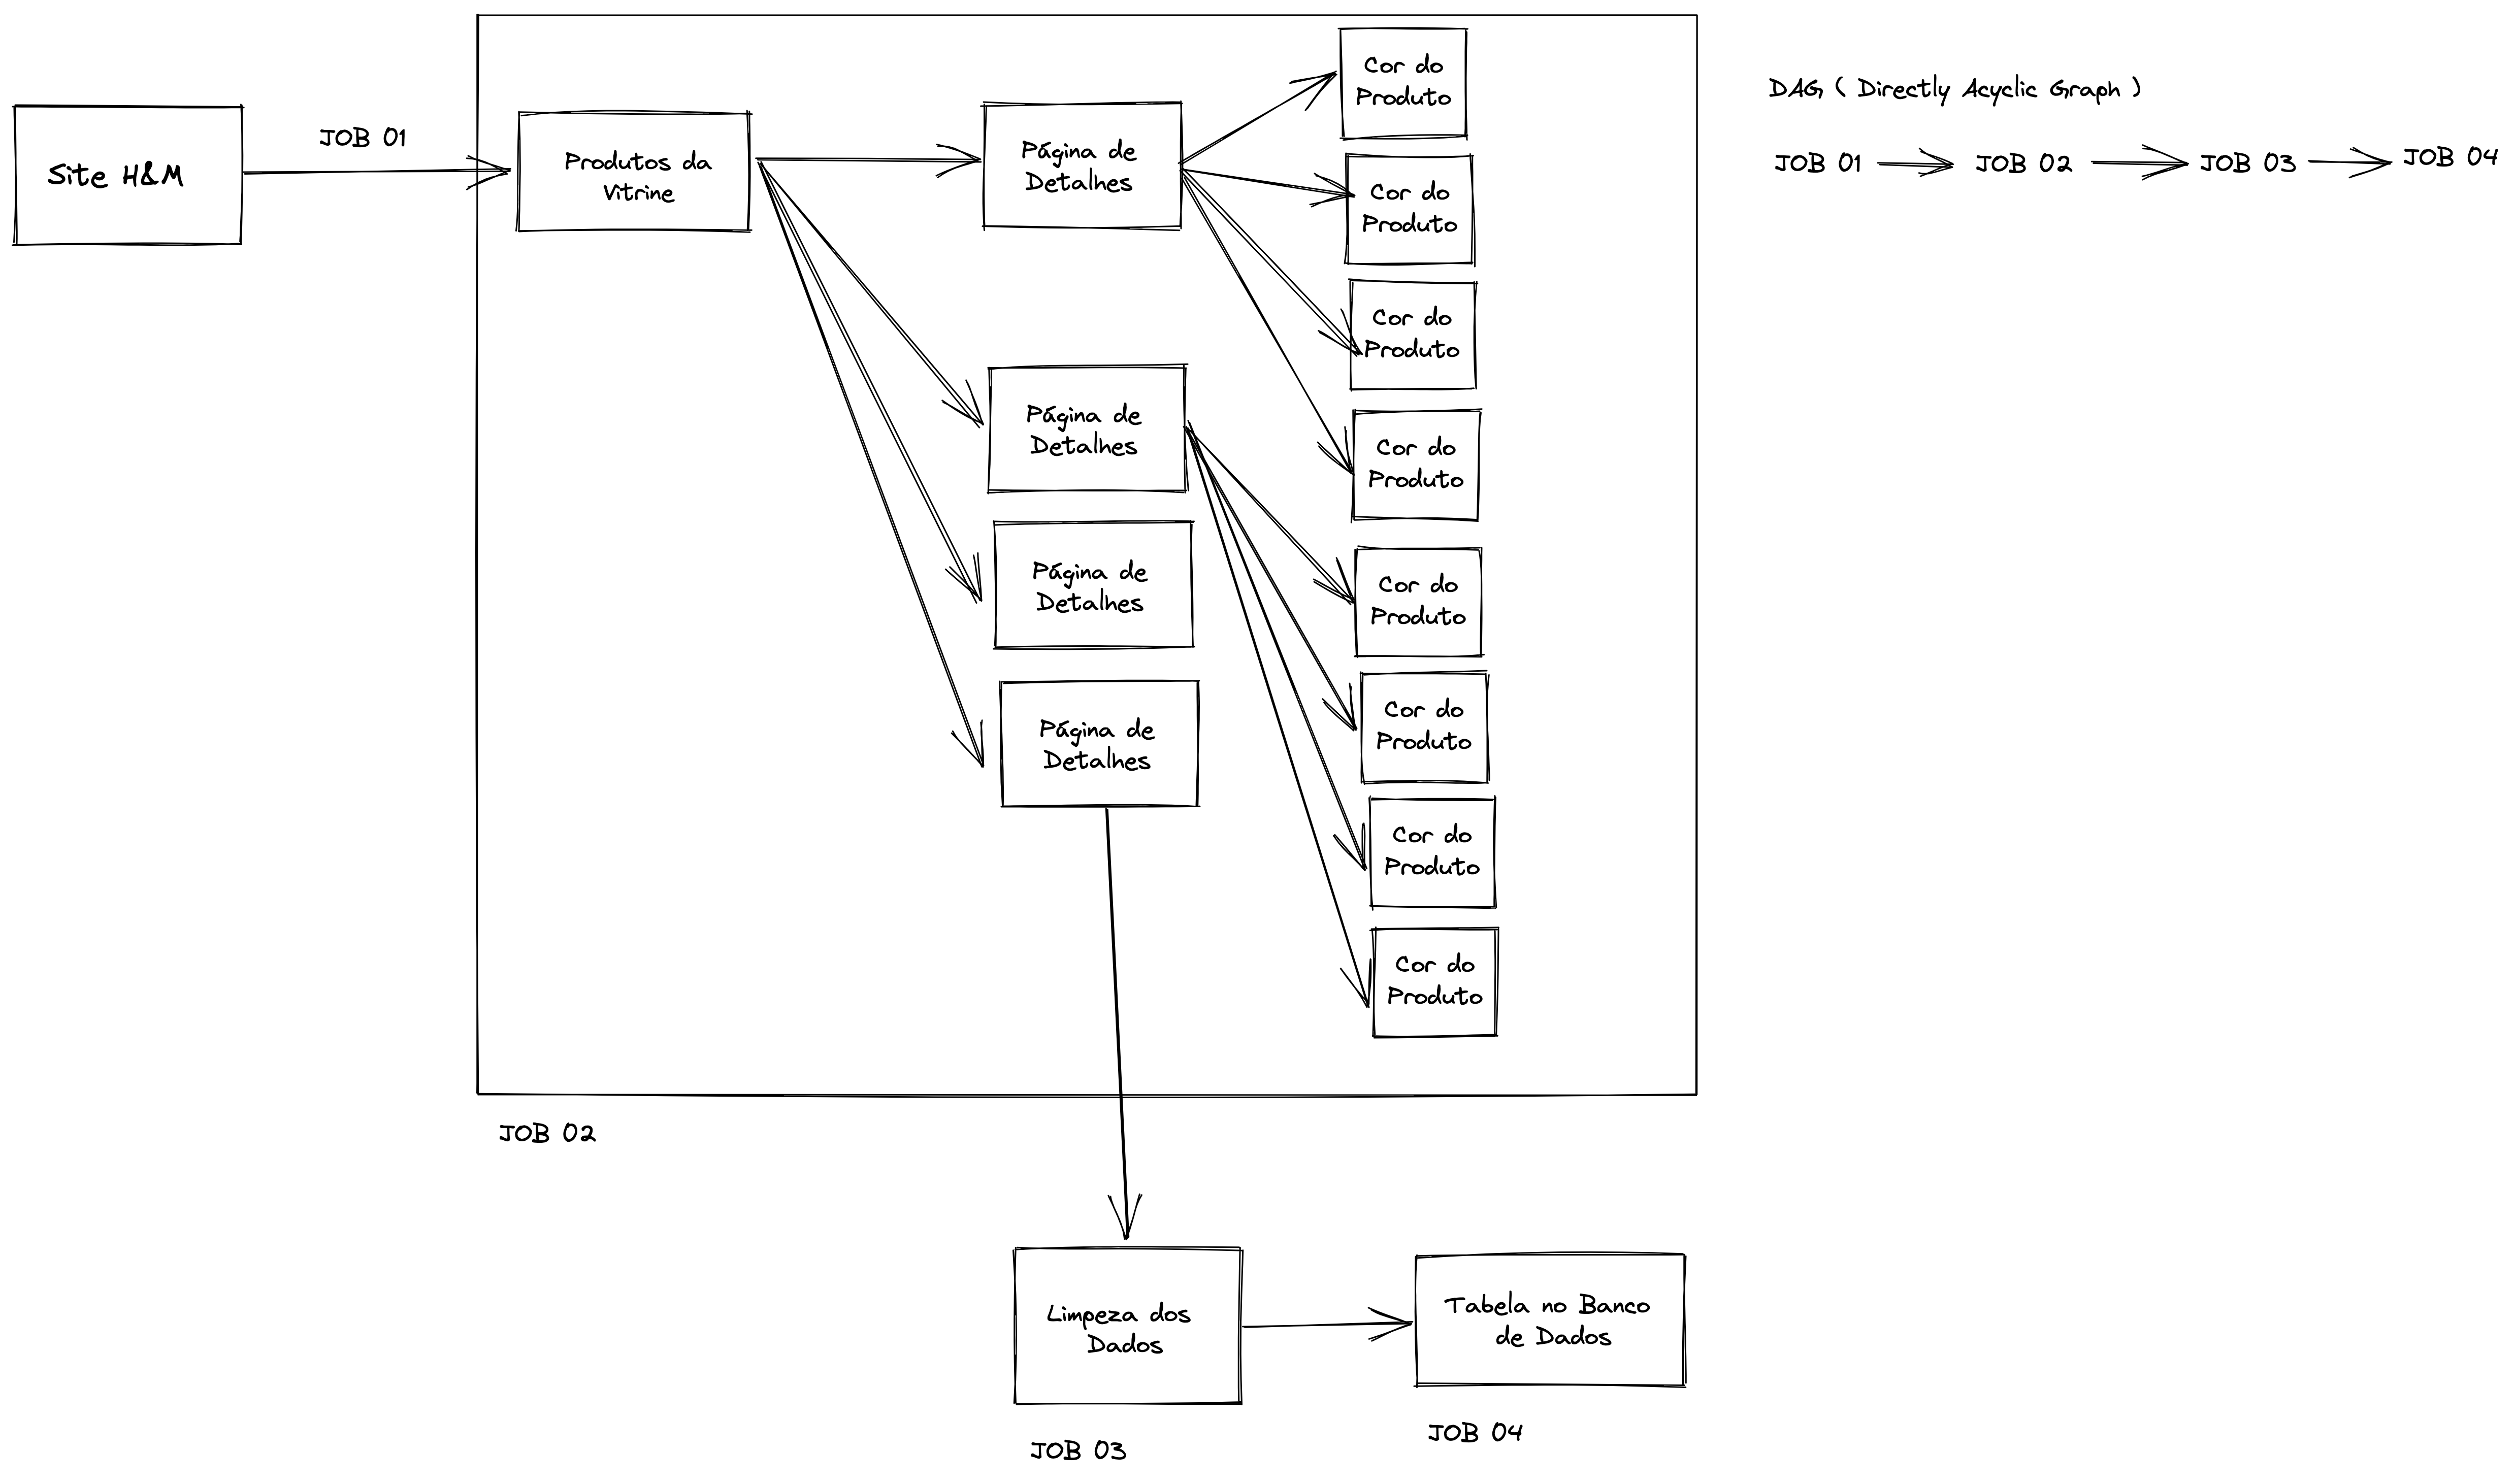

In [2]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/Desenho da arquitetura do ETL.png'
Image(filename = PATH, width=1000, height=1000)

### Data Collection

In [3]:
# parameters
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'}

# URL
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

# Request to URL
page = requests.get(url, headers = headers)

# Beautiful soup object
soup = BeautifulSoup(page.text, 'html.parser')

# ================================ Product Data ================================
products = soup.find ('ul', class_='products-listing small')
product_list = products.find_all('article', class_='hm-product-item')

# product id
product_id = [p.get('data-articlecode') for p in product_list]

# product category
product_category = [p.get('data-category') for p in product_list]

# product_name
product_list = products.find_all('a', class_='link')
product_name = [p.get_text() for p in product_list]

# price
product_list = products.find_all('span', class_='price regular')
product_price = [p.get_text() for p in product_list]

data = pd.DataFrame([product_id, product_category, product_name, product_price]).T
data.columns = ['product_id','product_category','product_name','product_price'] # renomenando as colunas


### Data Collection by Product

In [4]:
# Empty dataframe
df_compositions = pd.DataFrame()

# # Unique columns for all products
aux = []

df_pattern = pd.DataFrame(columns = ['Art. No.', 'Composition', 'Fit', 'Size'])

# Collecting products
for i in range (len(data)):
    # API Requests
    url = 'https://www2.hm.com/en_us/productpage.' + data.loc[i, 'product_id'] + '.html'
    print('Product: {}'.format(url))
    
    page = requests.get(url, headers = headers)
    
    # Beautiful Soup object
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # ====================================== Color Name ======================================
    product_list = soup.find_all('a', class_ = 'filter-option miniature active') + soup.find_all('a', class_ = 'filter-option miniature')
    color_name = [p.get('data-color') for p in product_list]

    # product id
    product_id = [p.get('data-articlecode') for p in product_list]

    df_color = pd.DataFrame([product_id, color_name]).T
    df_color.columns = ['product_id', 'color_name']
    
    # Collecting product information for each color
    for j in range (len(df_color)):
        # API Requests
        url = 'https://www2.hm.com/en_us/productpage.' + df_color.loc[j, 'product_id'] + '.html'
        print('Color: {}'.format(url))

        page = requests.get(url, headers = headers)
        
        # Beautiful Soup object
        soup = BeautifulSoup(page.text, 'html.parser')
        
        # ====================================== Product Name ======================================
        product_name = soup.find_all( 'section', class_='product-name-price')
        product_name = product_name[0].get_text()
        
        # ====================================== Product Price ======================================
        product_price = soup.find_all( 'div', class_='primary-row product-item-price')
        product_price = re.findall(r'\d+\.?\d+', product_price[0].get_text())[0]
    
        # ====================================== Composition ======================================
        product_composition_list = soup.find('div', class_='content pdp-text pdp-content').find_all('div')
        product_composition = [list(filter(None, p.get_text().split('\n'))) for p in product_composition_list]

        # Rename dataframe
        df_composition = pd.DataFrame(product_composition).T
        df_composition.columns = df_composition.iloc[0]

        # Delete first row
        df_composition = df_composition.iloc[1:].fillna(method='ffill')

        # Remove pocket lining, shell, lining and pocket
        df_composition['Composition'] = df_composition['Composition'].replace('Pocket lining: ', '', regex=True)
        df_composition['Composition'] = df_composition['Composition'].replace('Pocket: ', '', regex=True)
        df_composition['Composition'] = df_composition['Composition'].replace('Shell: ', '', regex=True)
        df_composition['Composition'] = df_composition['Composition'].replace('Lining: ', '', regex=True)

        # Garantee the same number of columns
        df_composition = pd.concat([df_pattern, df_composition], axis = 0)

        # Rename columns
        df_composition.columns = ['product_id', 'composition', 'fit', 'size']
        
        # New columns product_name and product_price
        df_composition['product_name'] = product_name
        df_composition['product_price'] = product_price

        # Keep new columns if it shows up
        aux = aux + df_composition.columns.tolist()

        # Merge data color + composition
        df_composition = pd.merge(df_composition, df_color, how='left', on = 'product_id')

        # All products
        df_compositions = pd.concat([df_compositions, df_composition], axis = 0)

# Join Showroom data + details
df_compositions['style_id'] = df_compositions['product_id'].apply(lambda x: x[:-3])
df_compositions['color_id'] = df_compositions['product_id'].apply(lambda x: x[-3:])

# scrapy datetime
df_compositions['scrapy_datetime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

Product: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm.com/en_us/productpage.0690449001.html
Color: https://www2.hm.com/en_us/productpage.0690449002.html
Color: https://www2.hm.com/en_us/productpage.0690449006.html
Color: https://www2.hm.com/en_us/productpage.0690449007.html
Color: https://www2.hm.com/en_us/productpage.0690449009.html
Color: https://www2.hm.com/en_us/productpage.0690449011.html
Color: https://www2.hm.com/en_us/productpage.0690449013.html
Color: https://www2.hm.com/en_us/productpage.0690449021.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.hm.com/en_us/productpage.0690449024.html
Color: https://www2.hm.com/en_us/productpage.0690449028.html
Color: https://www2.hm.com/en_us/productpage.0690449035.html
Color: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.hm.com/en_us/productpage.0690449040.html
Color: https://www2.hm

Color: https://www2.hm.com/en_us/productpage.0690449051.html
Color: https://www2.hm.com/en_us/productpage.0690449056.html
Color: https://www2.hm.com/en_us/productpage.0690449059.html
Color: https://www2.hm.com/en_us/productpage.0690449062.html
Color: https://www2.hm.com/en_us/productpage.0690449064.html
Color: https://www2.hm.com/en_us/productpage.0690449067.html
Product: https://www2.hm.com/en_us/productpage.1024256004.html
Color: https://www2.hm.com/en_us/productpage.1024256004.html
Color: https://www2.hm.com/en_us/productpage.1024256001.html
Color: https://www2.hm.com/en_us/productpage.1024256002.html
Color: https://www2.hm.com/en_us/productpage.1024256003.html
Color: https://www2.hm.com/en_us/productpage.1024256005.html
Color: https://www2.hm.com/en_us/productpage.1024256006.html
Color: https://www2.hm.com/en_us/productpage.1024256007.html
Color: https://www2.hm.com/en_us/productpage.1024256008.html
Product: https://www2.hm.com/en_us/productpage.0690449036.html
Color: https://www2.

Color: https://www2.hm.com/en_us/productpage.1013317012.html
Product: https://www2.hm.com/en_us/productpage.1099503002.html
Color: https://www2.hm.com/en_us/productpage.1099503002.html
Color: https://www2.hm.com/en_us/productpage.1099503001.html
Color: https://www2.hm.com/en_us/productpage.1099503003.html
Product: https://www2.hm.com/en_us/productpage.0690449059.html
Color: https://www2.hm.com/en_us/productpage.0690449059.html
Color: https://www2.hm.com/en_us/productpage.0690449001.html
Color: https://www2.hm.com/en_us/productpage.0690449002.html
Color: https://www2.hm.com/en_us/productpage.0690449006.html
Color: https://www2.hm.com/en_us/productpage.0690449007.html
Color: https://www2.hm.com/en_us/productpage.0690449009.html
Color: https://www2.hm.com/en_us/productpage.0690449011.html
Color: https://www2.hm.com/en_us/productpage.0690449013.html
Color: https://www2.hm.com/en_us/productpage.0690449021.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.

Color: https://www2.hm.com/en_us/productpage.1008110005.html
Color: https://www2.hm.com/en_us/productpage.1008110015.html
Color: https://www2.hm.com/en_us/productpage.1008110019.html


In [5]:
df_compositions.head()

,product_id,composition,fit,size,product_name,product_price,color_name,style_id,color_id,scrapy_datetime
0,0690449043,"Cotton 98%, Spandex 2%",Skinny fit,"The model is 183cm/6'0"" and wears a size 31/32",\n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n ...,39.99,Light denim blue/trashed,0690449,043,2022-11-29 17:34:35
1,0690449043,"Polyester 65%, Cotton 35%",Skinny fit,"The model is 183cm/6'0"" and wears a size 31/32",\n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n ...,39.99,Light denim blue/trashed,0690449,043,2022-11-29 17:34:35
0,0690449001,"Cotton 99%, Spandex 1%",Skinny fit,NaN,\n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n ...,13.99,Light denim blue/trashed,0690449,001,2022-11-29 17:34:35
0,0690449002,"Cotton 98%, Spandex 2%",Skinny fit,NaN,\n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n ...,14.99,Denim blue,0690449,002,2022-11-29 17:34:35
0,0690449006,"Cotton 98%, Spandex 2%",Skinny fit,NaN,\n\n\nSkinny Jeans\n\n\n\n\n\n\n\r\n ...,7.99,Black/washed,0690449,006,2022-11-29 17:34:35


### Data Cleaning

In [6]:
# product_id
df_data = df_compositions.dropna(subset = ['product_id'])

# product_name
df_data['product_name'] = df_data['product_name'].str.replace('\n', '')
df_data['product_name'] = df_data['product_name'].str.replace('\r', '-')
df_data['product_name'] =  df_data['product_name'].apply(lambda x: re.sub(r'-(.+)','', str(x)))
df_data['product_name'] = df_data['product_name'].str.replace(' ', '_').str.lower()

# product_price
df_data['product_price'] = df_data['product_price'].astype(float)

# color_name
df_data['color_name'] = df_data['color_name'].str.replace(' ', '_').str.lower()

# Fit
df_data['fit'] = df_data['fit'].apply(lambda x: x.replace(' ', '_').lower() if pd.notnull(x) else (x))

# size model
df_data['size_model'] = df_data['size'].apply(lambda x: re.search( '\d{3}cm', x).group(0) if pd.notnull(x) else x)
df_data['size_model'] = df_data['size_model'].apply(lambda x: re.search( '\d+', x).group(0) if pd.notnull(x) else x)

# size number
df_data['size_number'] = df_data['size'].str.extract('(\d+/\\d+)')

# Break composition by comma
df1 = df_data['composition'].str.split(',', expand = True).reset_index(drop=True)

# # ================================= Composition =================================

# Cotton | Spandex | Polyester
df_ref = pd.DataFrame(index = np.arange(len(df_data)), columns = ['cotton', 'spandex', 'polyester'])

# ======================= Search for cotton =======================
df_cotton_0 = df1.loc[df1[0].str.contains('Cotton', na=True), 0]
df_cotton_0.name = 'cotton'

df_cotton_1 = df1.loc[df1[1].str.contains('Cotton', na=True), 1]
df_cotton_1.name = 'cotton'

# Combine
df_cotton = df_cotton_0.combine_first(df_cotton_1)

df_ref = pd.concat( [df_ref, df_cotton], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep = 'last')]

# ======================= Search for polyester =======================
df_polyester_0 = df1.loc[df1[0].str.contains('Polyester', na=True), 0]
df_polyester_0.name = 'polyester'

df_polyester_1 = df1.loc[df1[1].str.contains('Polyester', na=True), 1]
df_polyester_1.name = 'polyester'

# Combine
df_polyester = df_polyester_0.combine_first(df_polyester_1)

df_ref = pd.concat([df_ref, df_polyester], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep = 'last')] 

# ======================= Search for spandex =======================
df_spandex_1 = df1.loc[df1[1].str.contains('Spandex', na=True), 1]
df_spandex_1.name = 'spandex'

df_spandex_2 = df1.loc[df1[2].str.contains('Spandex', na=True), 2]
df_spandex_2.name = 'spandex'

# Combine
df_spandex = df_spandex_1.combine_first(df_spandex_2)

df_ref = pd.concat([df_ref, df_spandex], axis=1)
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated(keep = 'last')]

# Join of combine with product_id
df_aux = pd.concat([df_data['product_id'].reset_index(drop=True), df_ref], axis=1)

# Format composition data
df_aux['cotton'] = df_aux['cotton'].apply(lambda x: int( re.search( '\d+', x).group(0) ) / 100 if pd.notnull(x) else x)
df_aux['spandex'] = df_aux['spandex'].apply(lambda x: int( re.search( '\d+', x).group(0) ) / 100 if pd.notnull(x) else x)
df_aux['polyester'] = df_aux['polyester'].apply(lambda x: int( re.search( '\d+', x).group(0) ) / 100 if pd.notnull(x) else x)

# Final join
df_aux = df_aux.groupby('product_id').max().reset_index().fillna(0)
df_data = pd.merge(df_data, df_aux, on='product_id', how='left')

# Drop columns: excluindo as colunas Size e Composition
df_data = df_data.drop(columns = ['size','composition'], axis=1)

# drop duplicates
df_data = df_data.drop_duplicates().reset_index(drop=True)
df_data.shape

(86, 13)

In [52]:
df_data

,product_id,fit,product_name,product_price,color_name,style_id,color_id,scrapy_datetime,size_model,size_number,cotton,polyester,spandex
0,0690449043,skinny_fit,skinny_jeans,39.99,light_denim_blue/trashed,0690449,043,2022-11-29 17:34:35,183,31/32,0.98,0.65,0.02
1,0690449001,skinny_fit,skinny_jeans,13.99,light_denim_blue/trashed,0690449,001,2022-11-29 17:34:35,NaN,NaN,0.99,0.00,0.01
2,0690449002,skinny_fit,skinny_jeans,14.99,denim_blue,0690449,002,2022-11-29 17:34:35,NaN,NaN,0.98,0.00,0.02
3,0690449006,skinny_fit,skinny_jeans,7.99,black/washed,0690449,006,2022-11-29 17:34:35,NaN,NaN,1.00,0.00,0.02
4,0690449007,skinny_fit,skinny_jeans,14.99,light_denim_blue,0690449,007,2022-11-29 17:34:35,NaN,NaN,1.00,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1004199003,skinny_fit,skinny_cropped_jeans,14.99,denim_blue,1004199,003,2022-11-29 17:34:35,185,NaN,0.99,0.65,0.01
82,1004199004,skinny_fit,skinny_cropped_jeans,29.99,white,1004199,004,2022-11-29 17:34:35,183,NaN,0.99,0.65,0.01
83,1004199005,skinny_fit,skinny_cropped_jeans,29.99,light_gray,1004199,005,2022-11-29 17:34:35,182,NaN,0.99,0.65,0.01
84,1100162003,regular_fit,essentials_no_2:_the_jeans,39.99,denim_gray,1100162,003,2022-11-29 17:34:35,187,31/32,0.99,0.65,0.01


## Data Insert

In [8]:
data_insert = df_data[[
    'product_id',
    'style_id',
    'color_id',
    'product_name',
    'color_name',
    'fit',
    'product_price',
    'size_number',
    'size_model',
    'cotton',
    'polyester',
    'spandex',
    'scrapy_datetime'
]]

In [9]:
query_showroom_schema = """
    CREATE TABLE vitrine(
    product_id       TEXT,
    style_id         TEXT,
    color_id         TEXT,
    product_name     TEXT,
    color_name       TEXT,
    fit              TEXT,
    product_price    REAL,
    size_number      TEXT,
    size_model       TEXT,
    cotton           REAL,
    polyester        REAL,
    spandex          REAL,
    scrapy_datetime  TEXT
    )
"""

In [10]:
# Creat table
conn = sqlite3.connect('database_hm.sqlite')
cursor = conn.execute(query_showroom_schema)
conn.commit()

In [11]:
# Create database connection
conn = create_engine( 'sqlite:///database_hm.sqlite', echo=False )

# Data insert
data_insert.to_sql('vitrine', con=conn, if_exists='append', index=False)

In [53]:
query = """
    SELECT * FROM vitrine
"""

df = pd.read_sql_query( query, conn )
df.head()

,product_id,style_id,color_id,product_name,color_name,fit,product_price,size_number,size_model,cotton,polyester,spandex,scrapy_datetime
0,0690449043,0690449,043,skinny_jeans,light_denim_blue/trashed,skinny_fit,39.99,31/32,183,0.98,0.65,0.02,2022-11-29 17:34:35
1,0690449001,0690449,001,skinny_jeans,light_denim_blue/trashed,skinny_fit,13.99,None,None,0.99,0.00,0.01,2022-11-29 17:34:35
2,0690449002,0690449,002,skinny_jeans,denim_blue,skinny_fit,14.99,None,None,0.98,0.00,0.02,2022-11-29 17:34:35
3,0690449006,0690449,006,skinny_jeans,black/washed,skinny_fit,7.99,None,None,1.00,0.00,0.02,2022-11-29 17:34:35
4,0690449007,0690449,007,skinny_jeans,light_denim_blue,skinny_fit,14.99,None,None,1.00,0.00,0.02,2022-11-29 17:34:35


In [54]:
df_raw = pd.read_sql(query, con=conn)

## Análise descritiva dos dados

### 1.0. Passo 01 - Descrição dos dados

In [55]:
df01 = df_raw.copy()

### 1.1. Dimensão dos dados

In [56]:
print( 'Number of Rows: {}'.format( df01.shape[0] ))
print( 'Number of Cols: {}'.format( df01.shape[1] ))

Number of Rows: 86
Number of Cols: 13


### 1.2. Tipos dos dados

In [57]:
df01.dtypes

product_id          object
style_id            object
color_id            object
product_name        object
color_name          object
fit                 object
product_price      float64
size_number         object
size_model          object
cotton             float64
polyester          float64
spandex            float64
scrapy_datetime     object
dtype: object

In [58]:
# Convert object to datetime
df01['scrapy_datetime'] = pd.to_datetime(df01['scrapy_datetime'])

In [59]:
df01.dtypes

product_id                 object
style_id                   object
color_id                   object
product_name               object
color_name                 object
fit                        object
product_price             float64
size_number                object
size_model                 object
cotton                    float64
polyester                 float64
spandex                   float64
scrapy_datetime    datetime64[ns]
dtype: object

### 1.3. Identificação de dados faltantes

In [60]:
df01.isna().sum()

product_id          0
style_id            0
color_id            0
product_name        0
color_name          0
fit                 0
product_price       0
size_number        42
size_model         32
cotton              0
polyester           0
spandex             0
scrapy_datetime     0
dtype: int64

In [61]:
df01.isna().sum() / df1.shape[0]

product_id        0.00
style_id          0.00
color_id          0.00
product_name      0.00
color_name        0.00
fit               0.00
product_price     0.00
size_number       0.07
size_model        0.05
cotton            0.00
polyester         0.00
spandex           0.00
scrapy_datetime   0.00
dtype: float64

### 1.4. Substituição de dados faltantes

In [62]:
# Estrategia: vamos dropar as colunas size_number e size_model porque não são necessárias para essa primeira análise.
df01 = df01.drop(columns=['size_number', 'size_model']).dropna()
df01.shape

(86, 11)

### 1.5. Descrição dos dados

In [63]:
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.5.1. Atributos numéricos

In [64]:
# tendencia central - media, mediana
t1 = pd.DataFrame(num_attributes.apply(np.mean)).T
t2 = pd.DataFrame(num_attributes.apply(np.median)).T

# disperson - desvio padrao (std), min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concat
m1 = pd.concat([d2, d3, d4, t1, t2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,product_price,7.99,49.99,42.00,30.33,29.99,11.03,0.01,-0.96
1,cotton,0.77,1.00,0.23,0.96,0.99,0.07,-2.12,3.04
2,polyester,0.00,1.00,1.00,0.43,0.65,0.34,-0.21,-1.54
3,spandex,0.00,0.02,0.02,0.01,0.01,0.01,-0.38,-0.74


#### 1.5.2. Atributos categóricos

In [65]:
cat_attributes.apply(lambda x: x.unique().shape[0])

product_id      86
style_id        11
color_id        31
product_name     9
color_name      23
fit              4
dtype: int64

## 2.0. Respondendo as questões de negócio

### 2.1. Quantos tipos de calças e suas cores para o produto inicial?

In [66]:
# Média de preço por modelos de calças
df_mean_price_by_style = df01[['fit','product_price']].groupby('fit').mean().sort_values('product_price', ascending=False).reset_index()
df_mean_price_by_style

,fit,product_price
0,loose_fit,39.99
1,slim_fit,31.85
2,regular_fit,29.10
3,skinny_fit,27.41


In [67]:
# Preço médio por modelos de calças
px.bar(df_mean_price_by_style, x="fit", y="product_price", title = "Preço médio por modelos de calça")

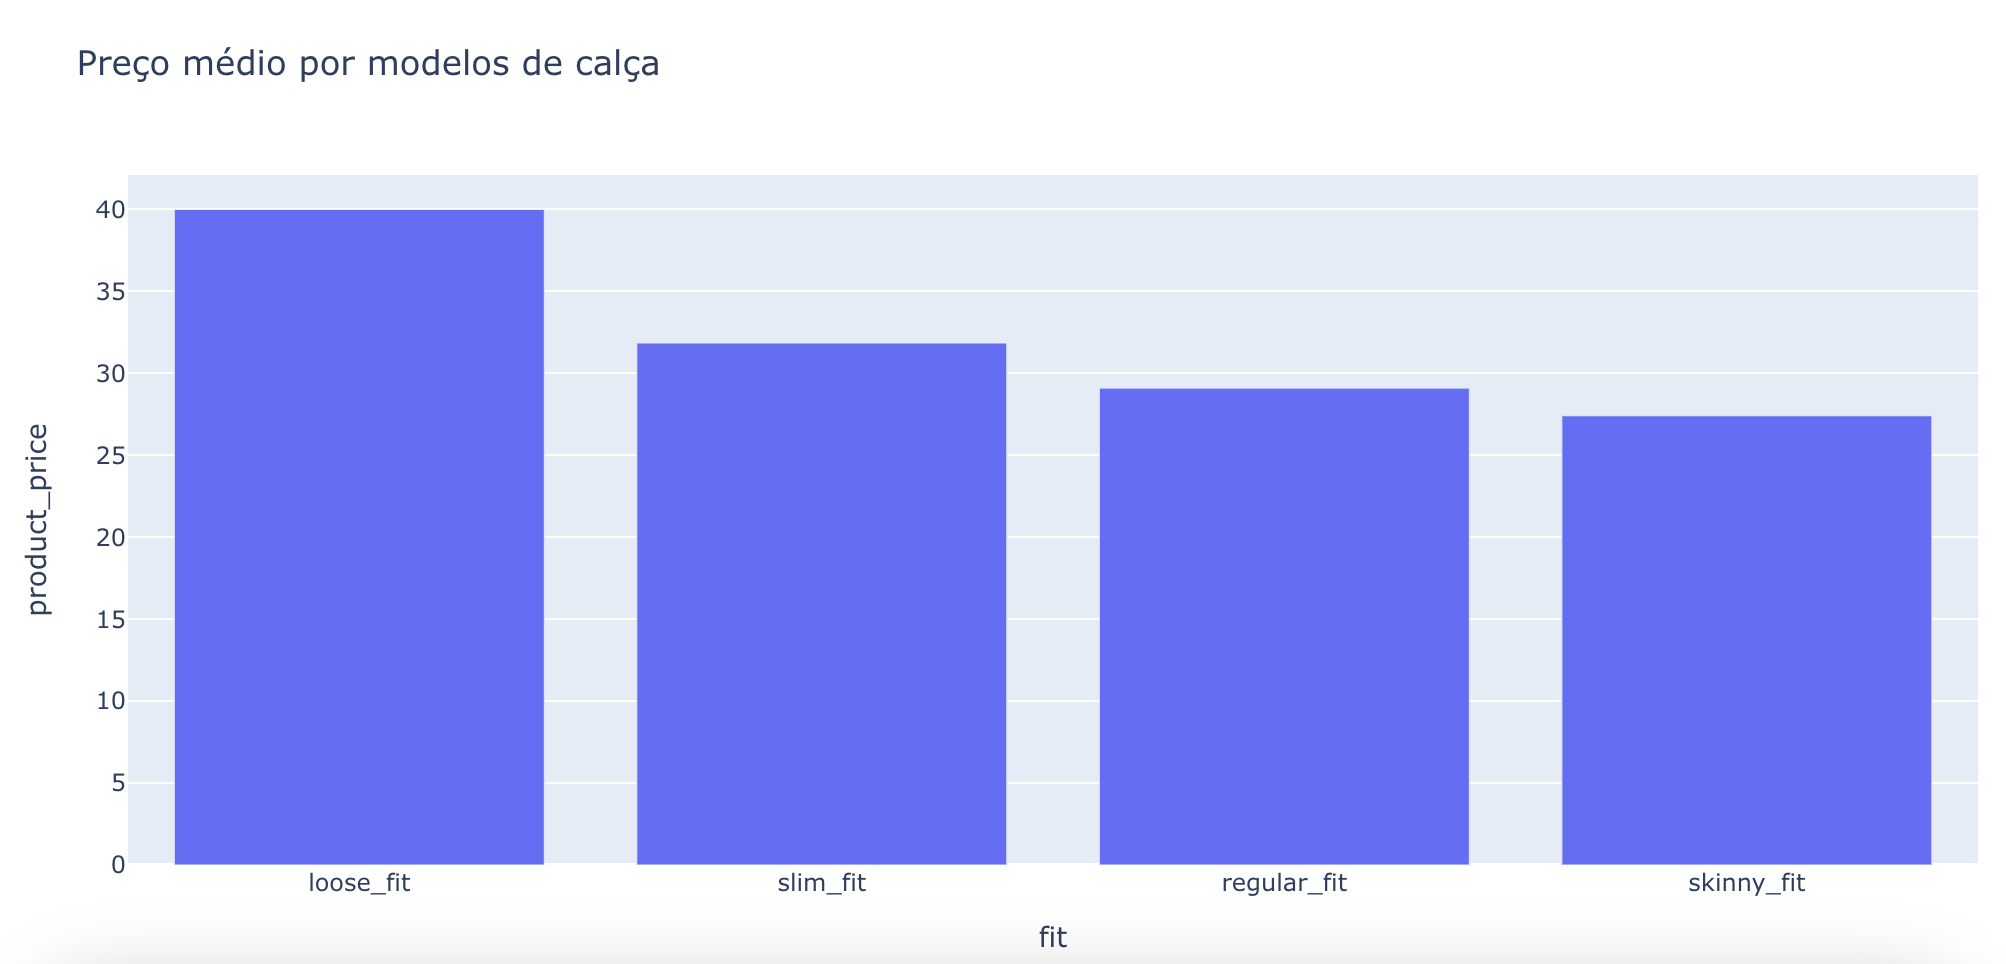

In [68]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph01.png'
Image(filename = PATH, width=1000, height=1000)

In [69]:
# Média de preço por cores de calças
df_mean_price_by_color = df01[['color_name','product_price']].groupby('color_name').mean().sort_values('product_price', ascending=False).reset_index()
df_mean_price_by_color

,color_name,product_price
0,black/no_fade_black,49.99
1,black/patterned,39.99
2,black/trashed,39.99
3,purple,39.99
4,light_denim_gray/trashed,39.99
5,gray,39.99
6,denim_gray,36.66
7,dark_denim_blue,32.85
8,black,32.61
9,light_denim_blue,31.46


In [70]:
# Preço médio por cores de calças
import plotly.express as px
px.bar(df_mean_price_by_color, x="color_name", y="product_price", title = "Preço médio por cores")

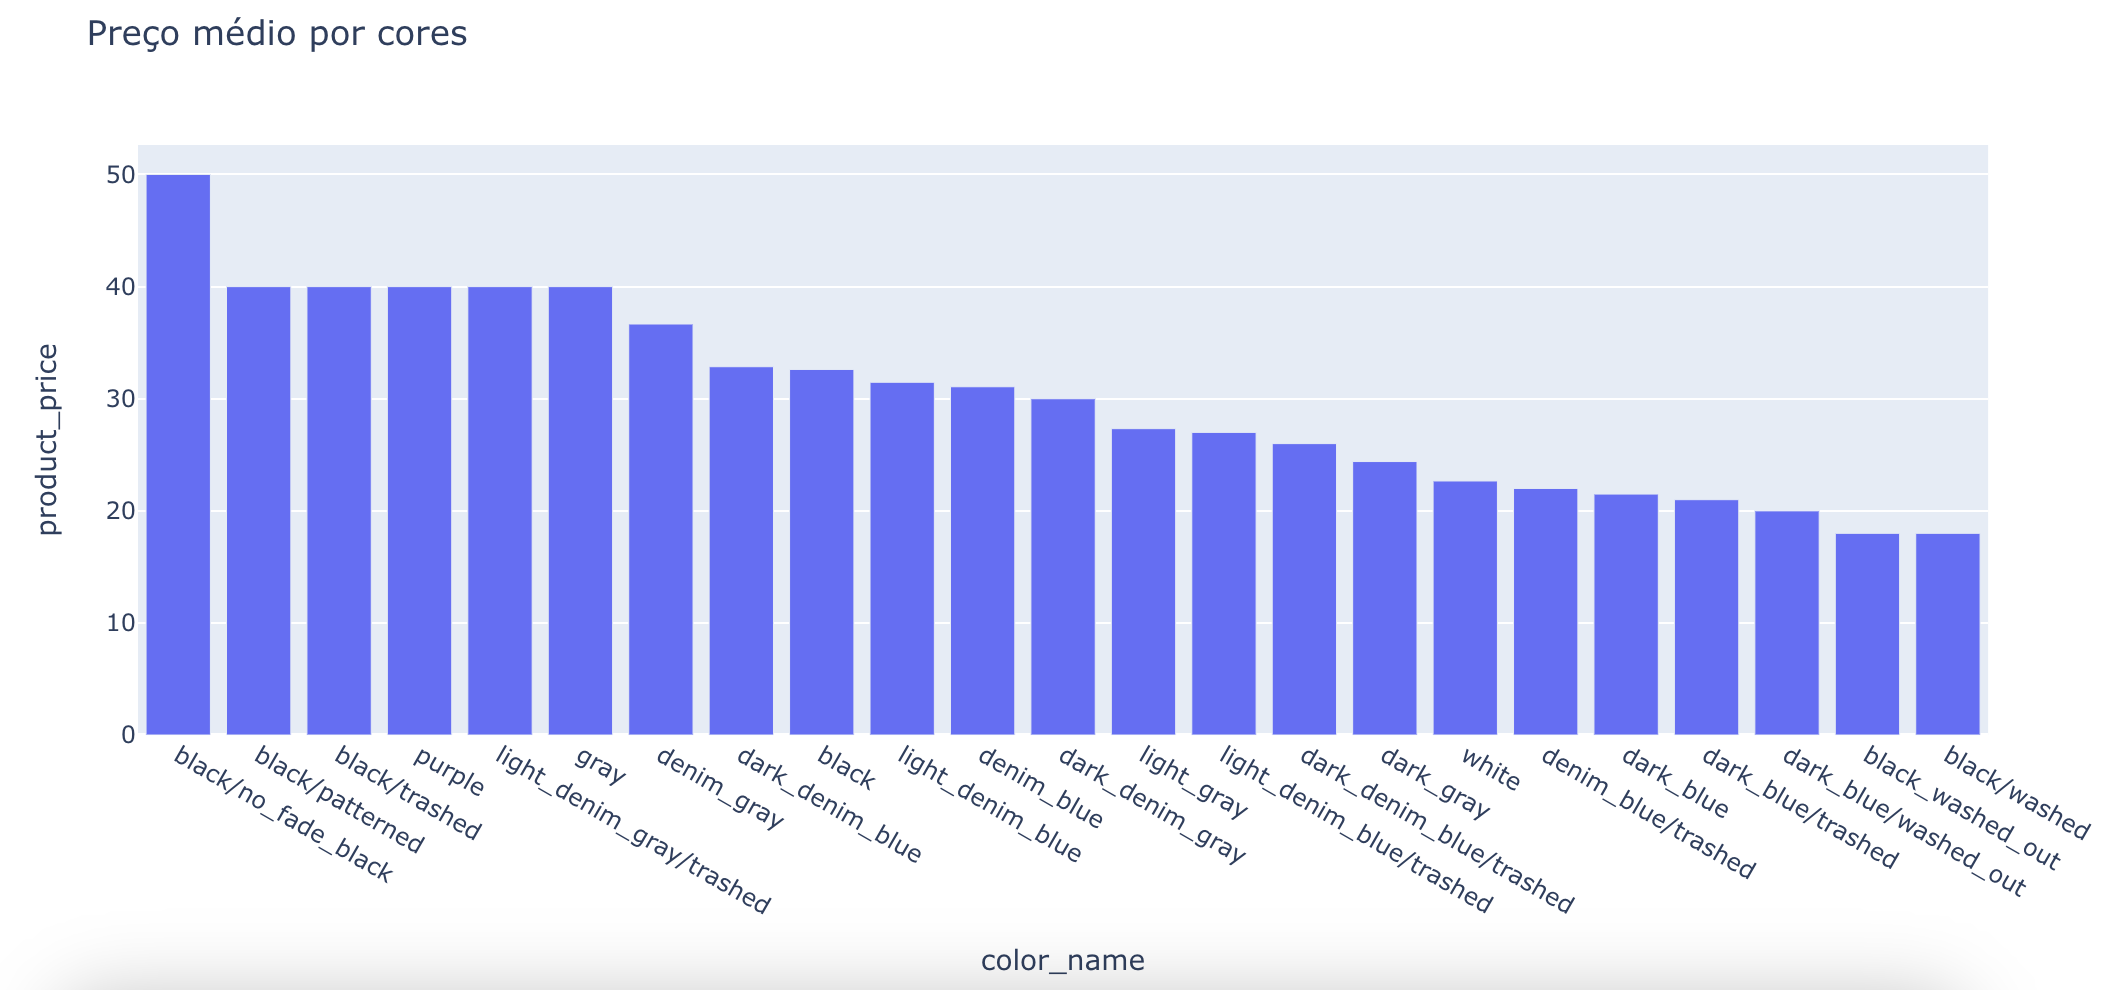

In [71]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph02.png'
Image(filename = PATH, width=1000, height=1000)

In [72]:
# Quantidade de modelos de calças por cores
fig = px.histogram(df01.drop_duplicates(subset = 'product_id'), x="color_name", color="fit", title = "Quantidade de modelos de calças por cores").update_xaxes(categoryorder='total descending')
fig.show()

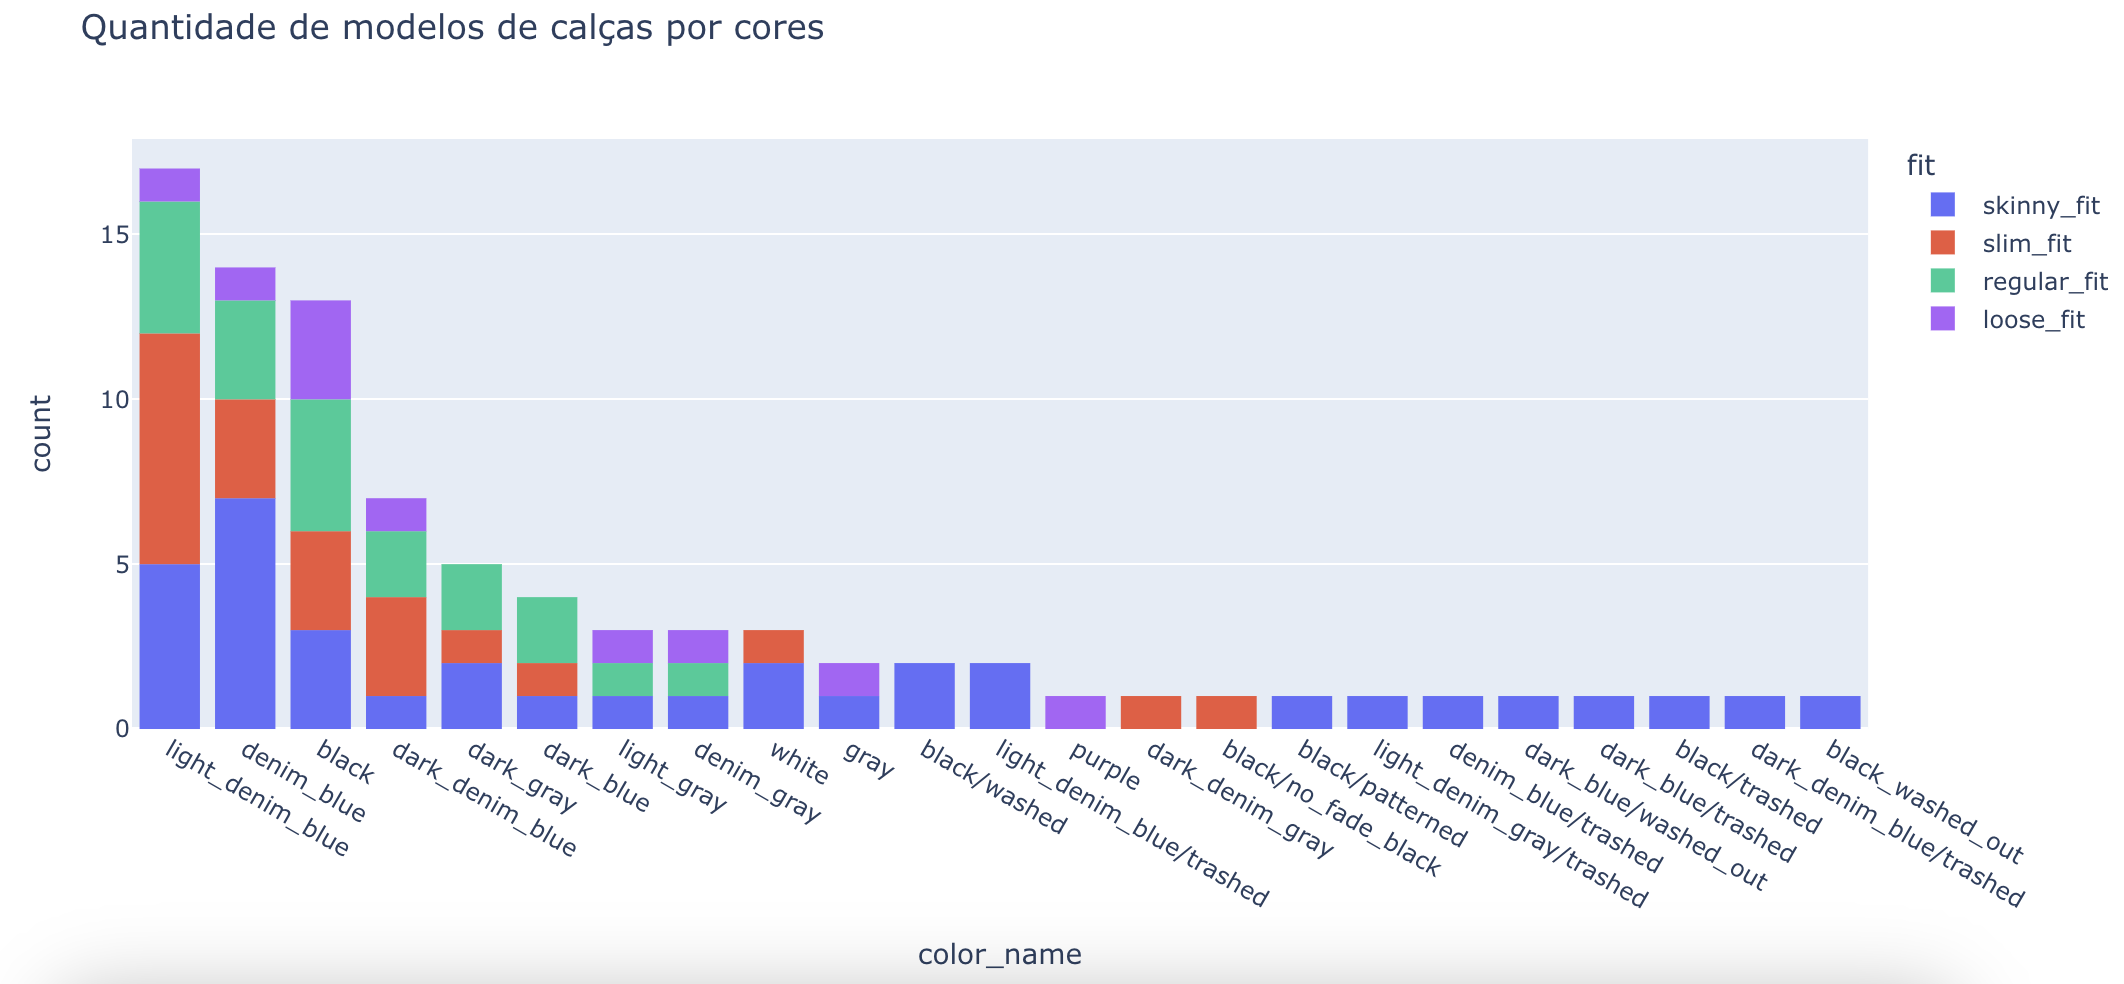

In [73]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph03.png'
Image(filename = PATH, width=1000, height=1000)

A sugestão na escolha das cores para as calças, é escolher uma cor que aparece em todos os modelos de calças. Assim podemos economizar com o preço do tecido aproveitando eles para todos os tipos de calças.

Como podemos ver no gráfico acima, as cores light_denim_blue, black, denim_blue e dark_denim_blue aparecem na maioria dos modelos de calça.

In [74]:
# Selecionando somente as cores destacadas na sugestão acima para ver quantos modelos de jeans que utilizam essas 4 cores.
df_jeans = df01[df01['color_name'].isin(['black', 'light_denim_blue', 'denim_blue', 'dark_denim_blue'])]

In [75]:
# Gráfico para identificar quais modelos de jeans utilizam as 4 cores escolhidas.
fig = px.histogram(df_jeans.drop_duplicates(subset = 'product_id'), x="fit", color="color_name", title = "Modelos de jeans que utilizam as quatro cores escolhidas").update_xaxes(categoryorder='total descending')
fig.show()

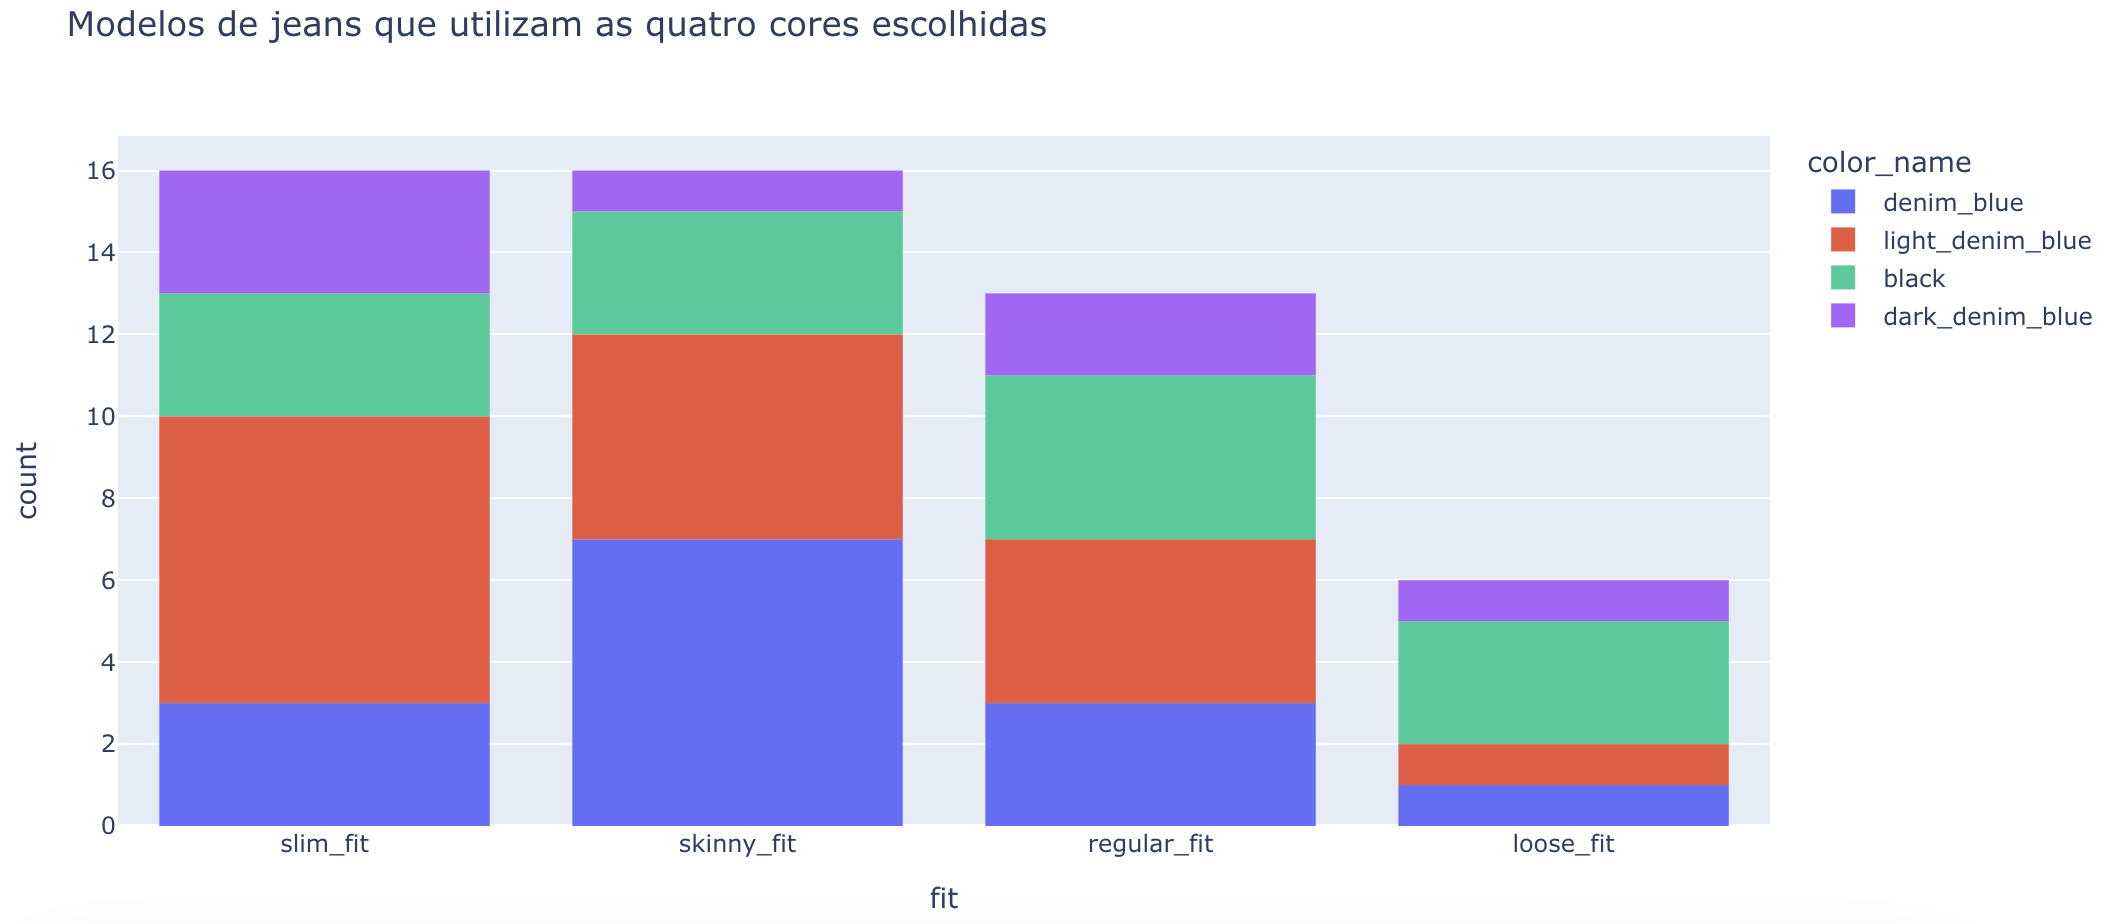

In [76]:
PATH = '/Users/deboragoncalves/Documents/repos/Projeto_trend_jeans/images/trend_jeans_graph04.png'
Image(filename = PATH, width=1000, height=1000)

A sugestão para a escolha dos modelos é utilizar modelos que tenham as 4 cores que escolhemos na sugestão anterior. 

Então nesse caso vamos escolher apenas 2 modelos de jeans para iniciar o negócio.

Modelos escolhidos:
- slim_fit
- skinny_fit

### 2.2. Quais as matérias-prima necessárias para confeccionar as calças?

In [77]:
# Selecionando somente os modelos e cores de jeans escolhidos, dropandos product_id duplicados para ver a matéria prima de cada um.
df_feedstock = df01[df01['fit'].isin(['slim_fit', 'skinny_fit'])
                   & df01['color_name'].isin(['light_denim_blue', 'black', 'denim_blue', 'dark_denim_blue'])].drop_duplicates(subset = 'product_id').reset_index()
df_feedstock

,index,product_id,style_id,color_id,product_name,color_name,fit,product_price,cotton,polyester,spandex,scrapy_datetime
0,2,0690449002,0690449,002,skinny_jeans,denim_blue,skinny_fit,14.99,0.98,0.00,0.02,2022-11-29 17:34:35
1,4,0690449007,0690449,007,skinny_jeans,light_denim_blue,skinny_fit,14.99,1.00,0.00,0.02,2022-11-29 17:34:35
2,13,0690449036,0690449,036,skinny_jeans,black,skinny_fit,39.99,0.98,0.00,0.02,2022-11-29 17:34:35
3,17,0690449056,0690449,056,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35
4,18,0690449059,0690449,059,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35
5,19,0690449062,0690449,062,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35
6,21,0690449067,0690449,067,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35
7,22,1024256001,1024256,001,slim_jeans,black,slim_fit,19.99,0.99,0.65,0.01,2022-11-29 17:34:35
8,23,1024256002,1024256,002,slim_jeans,light_denim_blue,slim_fit,19.99,0.99,0.65,0.01,2022-11-29 17:34:35
9,24,1024256003,1024256,003,slim_jeans,light_denim_blue,slim_fit,19.99,0.99,0.65,0.01,2022-11-29 17:34:35


### 2.3. Qual o melhor preço de venda para as calças?

Fazendo uma pesquisa de preços no Google em fornecedores da China, chegamos aos seguintes preços para os tecidos:
- Cotton m2: 1.15 - 1.6 USD
- Polyester m2: 1.9 - 2.01 USD
- Spandex m2: 1.95 - 2.15 USD

Pesquisando o salário médio de uma costureira nos Estados Unidos, chegamos no seguinte resultado:
- Salário base médio 16,70 USD por hora.

#### 2.3.1. Qual o melhor preço para bater o concorrente, incluindo preço do material e mão de obra de costura.

Estratégia 

- Calculo preço dos materiais:
    - Pegar a porcentagem de material de cada peça e se for maior que 0.50, multiplicar pelo preço máximo por metro quadrado do material vezes dois, considerando que vamos utilizar dois metros quadrados para montar a peça.
    - Se for menor que 0.50, multiplicar pelo preço máximo por metro quadrado do material, considerando que vamos utilizar apenas um metro quadrado para montar a peça.
   
- Calculo preço mão de obra
    - Pegar o salário base médio de 16,70 USD por hora e acrescentar em cada calça, considerando que uma costureira faz uma calça por hora.

In [95]:
# Preço cotton
def price_cotton(x):
    if (x['cotton'] > 0.50):
        return x['cotton'] * (1.6 * 2)
    else:
        return x['cotton'] * (1.6)
    
# Preço polyester
def price_polyester(x):
    if (x['polyester'] > 0.50):
        return x['polyester'] * (2.1 * 2)
    else:
        return x['polyester'] * (2.1)
    
# Preço spandex
def price_spandex(x):
    if (x['spandex'] > 0.50):
        return x['spandex'] * (2.15 * 2)
    else:
        return x['spandex'] * (2.15)

In [96]:
# Adicionando os preços de cada material
df_sales = df_feedstock.copy()

df_sales['price_cotton'] = df_sales.apply(price_cotton, axis = 1)

df_sales['price_polyester'] = df_sales.apply(price_polyester, axis = 1)

df_sales['price_spandex'] = df_sales.apply(price_spandex, axis = 1)

# Criando coluna de preço mao de obra por calça
df_sales['price_costureira'] = 16.70

# Criando coluna de preço total da calça, somando os materiais mais o preço de costureira
df_sales['total_price'] = df_sales['price_costureira'] + df_sales['price_spandex'] + df_sales['price_polyester'] + df_sales['price_cotton']

df_sales

,index,product_id,style_id,color_id,product_name,color_name,fit,product_price,cotton,polyester,spandex,scrapy_datetime,price_cotton,price_polyester,price_spandex,price_costureira,total_price
0,2,0690449002,0690449,002,skinny_jeans,denim_blue,skinny_fit,14.99,0.98,0.00,0.02,2022-11-29 17:34:35,3.14,0.00,0.04,16.70,19.88
1,4,0690449007,0690449,007,skinny_jeans,light_denim_blue,skinny_fit,14.99,1.00,0.00,0.02,2022-11-29 17:34:35,3.20,0.00,0.04,16.70,19.94
2,13,0690449036,0690449,036,skinny_jeans,black,skinny_fit,39.99,0.98,0.00,0.02,2022-11-29 17:34:35,3.14,0.00,0.04,16.70,19.88
3,17,0690449056,0690449,056,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61
4,18,0690449059,0690449,059,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61
5,19,0690449062,0690449,062,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61
6,21,0690449067,0690449,067,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61
7,22,1024256001,1024256,001,slim_jeans,black,slim_fit,19.99,0.99,0.65,0.01,2022-11-29 17:34:35,3.17,2.73,0.02,16.70,22.62
8,23,1024256002,1024256,002,slim_jeans,light_denim_blue,slim_fit,19.99,0.99,0.65,0.01,2022-11-29 17:34:35,3.17,2.73,0.02,16.70,22.62
9,24,1024256003,1024256,003,slim_jeans,light_denim_blue,slim_fit,19.99,0.99,0.65,0.01,2022-11-29 17:34:35,3.17,2.73,0.02,16.70,22.62


#### 2.3.2. Calcular o lucro de cada peça, tirando o preço do material e mão de obra de costura

Calculo de lucro:
- Ver quantas peças podemos ter lucro, subtraindo o preço do concorrente do total price.
- Desconsideraremos peças que apresentarem valores negativos.
- Vamos fabricar e vender as peças onde podemos obter o mesmo preço do concorrente com a mão de obra e lucro, dando 10% de desconto no preço final dessa peça para batermos o preço do concorrente.

In [97]:
# Calculo de diferença do concorrente: preço do concorrente - preço total da nossa calça
df_sales['dif_concorrente'] = df_sales['product_price'] - df_sales['total_price']

In [98]:
# Criar coluna de preço final somando o preço total com a diferença do concorrente menos 10% de desconto para bater o preço do concorrente
df_sales['final_price'] = (df_sales['total_price'] + df_sales['dif_concorrente'])
df_sales['final_price'] = df_sales['final_price'] - (df_sales['final_price'] * 0.10)
df_sales[(df_sales['dif_concorrente'] > 0)]

,index,product_id,style_id,color_id,product_name,color_name,fit,product_price,cotton,polyester,spandex,scrapy_datetime,price_cotton,price_polyester,price_spandex,price_costureira,total_price,dif_concorrente,final_price
2,13,0690449036,0690449,036,skinny_jeans,black,skinny_fit,39.99,0.98,0.00,0.02,2022-11-29 17:34:35,3.14,0.00,0.04,16.70,19.88,20.11,35.99
3,17,0690449056,0690449,056,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99
4,18,0690449059,0690449,059,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99
5,19,0690449062,0690449,062,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99
6,21,0690449067,0690449,067,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99
11,27,1024256006,1024256,006,slim_jeans,dark_denim_blue,slim_fit,19.99,1.00,0.00,0.01,2022-11-29 17:34:35,3.20,0.00,0.02,16.70,19.92,0.07,17.99
12,30,0985159001,0985159,001,skinny_jeans,black,skinny_fit,24.99,1.00,0.00,0.01,2022-11-29 17:34:35,3.20,0.00,0.02,16.70,19.92,5.07,22.49
13,31,0985159002,0985159,002,skinny_jeans,denim_blue,skinny_fit,24.99,1.00,0.00,0.01,2022-11-29 17:34:35,3.20,0.00,0.02,16.70,19.92,5.07,22.49
14,33,0985159004,0985159,004,skinny_jeans,light_denim_blue,skinny_fit,24.99,1.00,0.00,0.01,2022-11-29 17:34:35,3.20,0.00,0.02,16.70,19.92,5.07,22.49
15,35,0985159006,0985159,006,skinny_jeans,dark_denim_blue,skinny_fit,24.99,0.99,0.65,0.01,2022-11-29 17:34:35,3.17,2.73,0.02,16.70,22.62,2.37,22.49


In [99]:
# Criar coluna de lucro subtraindo o preço total com o preço final.
df_sales['lucro'] = (df_sales['final_price'] - df_sales['total_price'])
df_sales[(df_sales['lucro'] > 0)]

,index,product_id,style_id,color_id,product_name,color_name,fit,product_price,cotton,polyester,spandex,scrapy_datetime,price_cotton,price_polyester,price_spandex,price_costureira,total_price,dif_concorrente,final_price,lucro
2,13,0690449036,0690449,036,skinny_jeans,black,skinny_fit,39.99,0.98,0.00,0.02,2022-11-29 17:34:35,3.14,0.00,0.04,16.70,19.88,20.11,35.99,16.11
3,17,0690449056,0690449,056,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99,13.38
4,18,0690449059,0690449,059,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99,13.38
5,19,0690449062,0690449,062,skinny_jeans,light_denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99,13.38
6,21,0690449067,0690449,067,skinny_jeans,denim_blue,skinny_fit,39.99,0.98,0.65,0.02,2022-11-29 17:34:35,3.14,2.73,0.04,16.70,22.61,17.38,35.99,13.38
12,30,0985159001,0985159,001,skinny_jeans,black,skinny_fit,24.99,1.00,0.00,0.01,2022-11-29 17:34:35,3.20,0.00,0.02,16.70,19.92,5.07,22.49,2.57
13,31,0985159002,0985159,002,skinny_jeans,denim_blue,skinny_fit,24.99,1.00,0.00,0.01,2022-11-29 17:34:35,3.20,0.00,0.02,16.70,19.92,5.07,22.49,2.57
14,33,0985159004,0985159,004,skinny_jeans,light_denim_blue,skinny_fit,24.99,1.00,0.00,0.01,2022-11-29 17:34:35,3.20,0.00,0.02,16.70,19.92,5.07,22.49,2.57
17,53,1024711006,1024711,006,slim_jeans,dark_denim_blue,slim_fit,29.99,1.00,0.00,0.02,2022-11-29 17:34:35,3.20,0.00,0.04,16.70,19.94,10.05,26.99,7.05
18,54,1024711001,1024711,001,slim_jeans,black,slim_fit,29.99,1.00,0.00,0.02,2022-11-29 17:34:35,3.20,0.00,0.04,16.70,19.94,10.05,26.99,7.05
